In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import norm

In [47]:
# Pricing the barrier option, implementing CEP method
def MC_euler_CEP(
        call: bool ,
        barrier: float ,
        S_0: float,
        K:float,
        r:float,
        sigma: float,
        T: float,
        gamma: float,
        num_samples: int,
        num_steps: int):

    S = np.repeat(S_0, num_samples)
    dt = T / num_steps
    dtype = [('float_value' , 'float64'), ('bool_value', 'bool')]

    if barrier > S_0:
        crossed_or_not = np.ones(num_samples , dtype=dtype)
        crossed_or_not['float_value'] = S_0
        sigma_diff = sigma**2 * dt

        for _ in range(num_steps):
            S_old = S.copy()
            dW = np.random.normal(0, np.sqrt(dt), num_samples)
            S = S * np.exp((r - (sigma**2 / 2)) * dt + sigma * dW)

            P_crossed = np.exp( -2 * ((barrier - S_old) * (barrier - S)) / (sigma_diff * S_old**2))
            P_uniform = np.random.uniform(0 , 1 , num_samples)

            indices_1 = np.where(S >= barrier)[0]
            indices_2 = np.where(P_crossed > P_uniform)[0]
            indices = np.unique(np.concatenate((indices_1 , indices_2)))
            crossed_or_not['bool_value'][indices] = False

            crossed_or_not['float_value'] = np.where(crossed_or_not['bool_value'], S, crossed_or_not['float_value'])

        if call:
            E_payoff = np.mean(np.maximum(crossed_or_not['float_value'] - K, 0))
            E_discounted_payoff = np.exp(-r*T) * E_payoff
            return E_discounted_payoff
        else:
            E_payoff = np.mean(np.maximum(K - crossed_or_not['float_value'], 0))
            E_discounted_payoff = np.exp(-r*T) * E_payoff
            return E_discounted_payoff
    else:
        raise TypeError("This option can't exist, initital stock price has crossed the barrier")

MC_euler_CEP(True , 16 , 14 , 15 , 0.1 , 0.25 , 0.5 , 1 , 100000 , 1000)

0.4543367919441125

In [ ]:
# Monte Carlo for a vanilla call option with anti variates method
def MC_euler_maruyama_av(S_0: float, K:float, r:float, sigma: float, T: float, gamma: float, num_samples: int, num_steps: int):
    S = np.repeat(S_0, num_samples)
    num_samples_half = (num_samples + 1) // 2
    dW = np.zeros(num_samples)
    dt = T / num_steps
    for _ in range(num_steps):
        dW[:num_samples_half] = np.random.normal(0, np.sqrt(dt), num_samples_half)
        dW[num_samples_half:] = -dW[:num_samples_half]
        S = S * np.exp((r - (sigma**2 / 2)) * dt + sigma * dW)
    E_payoff = np.mean(np.maximum(S - K, 0))
    E_discounted_payoff = np.exp(-r*T) * E_payoff
    return E_discounted_payoff

8
9
10
11
12
13
14
15


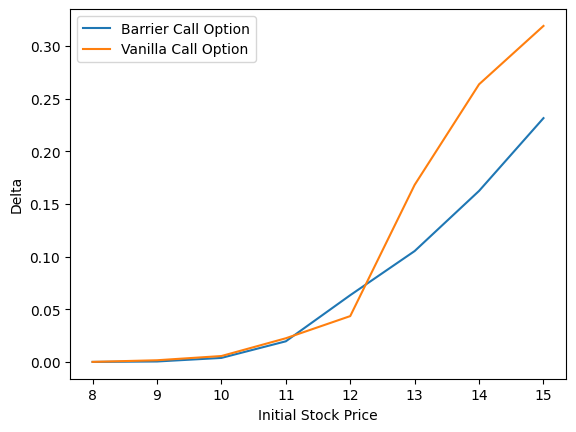

In [ ]:
def delta_barrier(S_0: float , epsilon: float, call: bool , strike , barrier):
  return (MC_euler_CEP(call , barrier , S_0 + epsilon , strike , 0.1 , 0.25 , 0.5 , 1 , 100000 , 500) - MC_euler_maruyama(call , barrier , S_0 , strike , 0.1 , 0.25 , 0.5 , 1 , 100000 , 500)) / epsilon


def delta_vanilla(S_0: float , epsilon: float , strike):
  return (MC_euler_maruyama_av(S_0 + epsilon , strike , 0.1 , 0.25 , 0.5 , 1 , 100000 , 500) - MC_euler_maruyama_av(S_0 , strike , 0.1 , 0.25 , 0.5 , 1 , 100000 , 500)) / epsilon

#print(f'Delta value for barrier option: {delta_barrier(15 , 0.15 , True , 17 , 19)}. Delta value for vanilla option: {delta_vanilla(15 , 0.15 , 17)}')

barrier=[]
vanilla=[]
for s in range(8,16):
    barrier.append(delta_barrier(s , 0.15 , True , 17 , 19))
    vanilla.append(delta_vanilla(s , 0.15 , 17))

s=np.arange(8,16,1)
plt.plot(s,barrier,label='Barrier Call Option')
plt.plot(s,vanilla,label='Vanilla Call Option')
plt.xlabel('Initial Stock Price')
plt.ylabel('Delta')
plt.legend()


In [44]:
#whitout CEP-method

def MC_euler_basic(
        call: bool ,
        barrier: float ,
        S_0: float,
        K:float,
        r:float,
        sigma: float,
        T: float,
        gamma: float,
        num_samples: int,
        num_steps: int):

    S = np.repeat(S_0, num_samples)
    dt = T / num_steps
    dtype = [('float_value' , 'float64'), ('bool_value', 'bool')]

    if barrier > S_0:
        crossed_or_not = np.ones(num_samples , dtype=dtype)
        crossed_or_not['float_value'] = S_0

        for _ in range(num_steps):
            S_old = S.copy()
            dW = np.random.normal(0, np.sqrt(dt), num_samples)
            S = S * np.exp((r - (sigma**2 / 2)) * dt + sigma * dW)
            indices = np.where(S > barrier)[0]
            crossed_or_not['bool_value'][indices] = False
            crossed_or_not['float_value'] = np.where(crossed_or_not['bool_value'], S, crossed_or_not['float_value'])

        if call:
            E_payoff = np.mean(np.maximum(crossed_or_not['float_value'] - K, 0))
            E_discounted_payoff = np.exp(-r*T) * E_payoff
            return E_discounted_payoff
        else:
            E_payoff = np.mean(np.maximum(K - crossed_or_not['float_value'], 0))
            E_discounted_payoff = np.exp(-r*T) * E_payoff
            return E_discounted_payoff
    else:
        raise TypeError("This option can't exist, initital stock price has crossed the barrier")

MC_euler_basic(True , 16 , 14 , 15 , 0.1 , 0.25 , 0.5 , 1 , 100000 , 1000)

0.4574777983428579

In [46]:
#By Hull
from numpy import exp, log, sqrt
from scipy.special import erf
from scipy.stats import norm

def get_c(B:float, sigma: float, r: float, K: float, T: float, S: float):
  d1 = (log(S / K) + (r + (sigma**2) / 2) * T) / (sigma * sqrt(T))
  d2 = d1 - sigma * sqrt(T)
  c = S * exp(0) * norm.cdf(d1) - K * exp(-r * T) * norm.cdf(d2)
  return c

def analytic_solution_call_up_in(S0, K, H, T, r, q, sigma):
    lambda_ = (r - q + 0.5 * (sigma**2)) / (sigma**2)

    y = (log((H**2) / (S0 * K))) / (sigma * sqrt(T)) + lambda_ * sigma * sqrt(T)

    x1 = log(S0 / H) / (sigma * sqrt(T)) + lambda_ * sigma * sqrt(T)
    y1 = log(H / S0) / (sigma * sqrt(T)) + lambda_ * sigma * sqrt(T)

    term1 = S0 * norm.cdf(x1) * exp(0)
    term2 = K * exp(-r * T) * norm.cdf(x1 - sigma * sqrt(T))
    term3 = S0 * exp(0) * ((H / S0)**(2 * lambda_)) * (norm.cdf(-y) - norm.cdf(-y1))
    term4 = K * exp(-r * T) * ((H / S0)**(2 * lambda_ - 2)) * (norm.cdf(-y + sigma * sqrt(T)) - norm.cdf(-y1 + sigma * sqrt(T)))

    cui = term1 - term2 - term3 + term4

    return cui

def analytic_solution_call_up_out(B:float, sigma: float, r: float, K: float, T: float, S: float):
  c = get_c(B, sigma, r, K, T, S)
  if B <= K:
    cuo = 0
  else:
    cui = analytic_solution_call_up_in(S, K, B, T, r, 0, sigma)

    cuo = c - cui

  return cuo

S0 = 14  # Current stock price
K = 15    # Strike price
B = 16   # Barrier level
T = 0.5     # Time to maturity in years
r = 0.1  # Risk-free interest rate
sigma = 0.25  # Volatility (25%)

price = analytic_solution_call_up_out(B, sigma, r, K, T, 14)
print(price)


0.010173294983612857


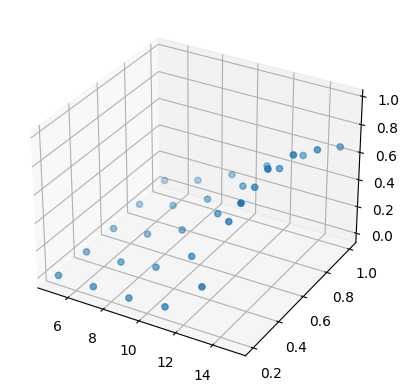

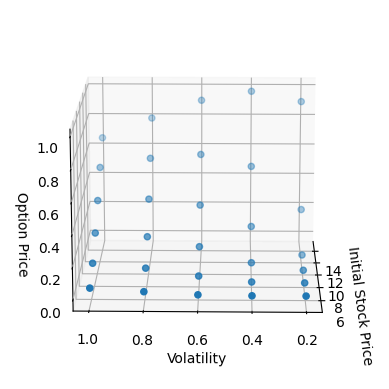

[0.2 0.4 0.6 0.8 1. ]
[15. 15. 15. 15. 15.]


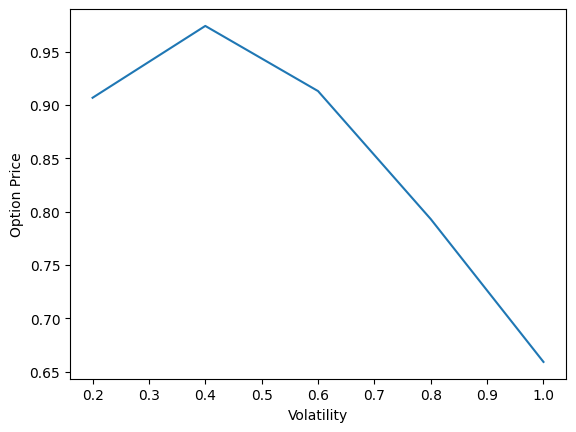

[0.2 0.4 0.6 0.8 1. ]
[5. 5. 5. 5. 5.]


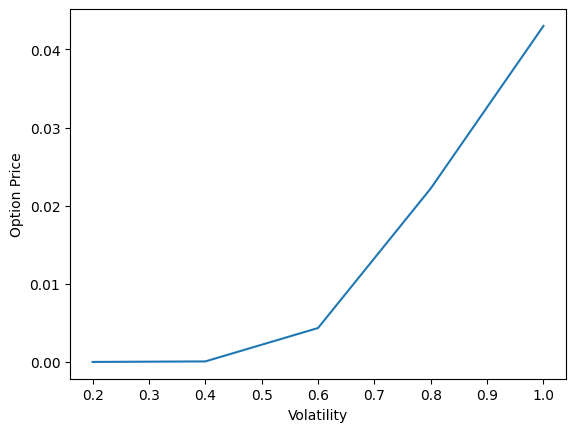

In [ ]:
#Ploting the option price regrading the volatility and starting stock price
#It is a simple code but it can visualize I think that when we are far from the barrier the bigger volatility is great but near to the barrier at some point it is not that good.
result=np.array([])
x=np.array([])
y=np.array([])
for s in range(5,16,2):

    for vol in np.arange(0.2,1.1,0.2):

        result=np.append(result,MC_euler_CEP(True , 17 , s , 15 , 0.1 , vol , 0.5 , 1 , 100000 , 100))
        x=np.append(x,s)
        y=np.append(y,vol)

ax = plt.axes(projection='3d')
ax.scatter(x, y, result)
plt.show()
ax = plt.axes(projection='3d')
ax.scatter(x, y, result)
ax.view_init(15, -179)
ax.set_xlabel('Initial Stock Price')
ax.set_ylabel('Volatility')
ax.set_zlabel('Option Price')
plt.show()
print(y[-5:])
print(x[-5:])
plt.plot(y[-5:],result[-5:])
plt.xlabel('Volatility')
plt.ylabel('Option Price')
plt.show()
print(y[:5])
print(x[:5])
plt.plot(y[:5],result[:5])
plt.xlabel('Volatility')
plt.ylabel('Option Price')
plt.show()


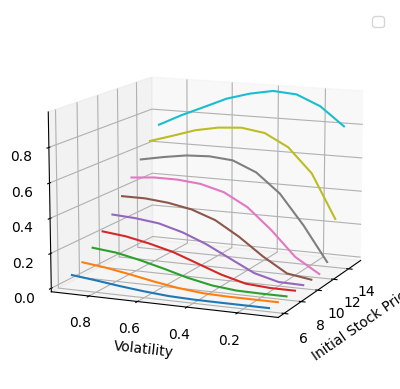

In [ ]:
#Better plot
result=np.array([])
x=np.array([])
y=np.array([])
ax = plt.axes(projection='3d')
for s in range(6,16,1):
    for vol in np.arange(0.1,1,0.1):
        result=np.append(result,MC_euler_CEP(True , 17 , s , 15 , 0.1 , vol , 0.5 , 1 , 100000 , 100))
        x=np.append(x,s)
        y=np.append(y,vol)
    ax.plot3D(x,y,result)
    result=np.array([])
    x=np.array([])
    y=np.array([])

ax.view_init(12, -157)
ax.set_xlabel('Initial Stock Price')
ax.set_ylabel('Volatility')
ax.set_zlabel('Option Price')
plt.legend()
plt.show()

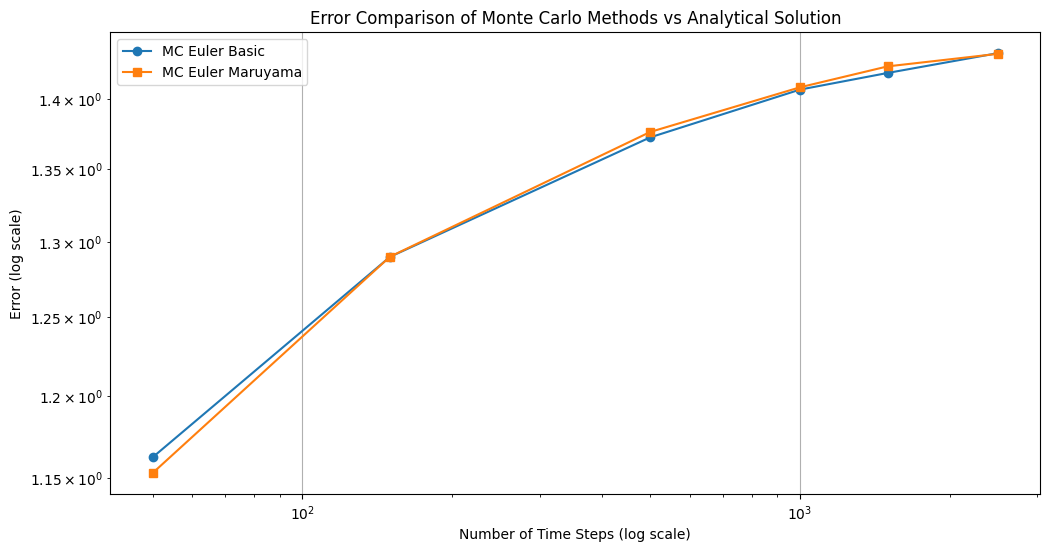

In [32]:
S0 = 16  # Current stock price
K = 15    # Strike price
B = 17   # Barrier level
T = 0.5     # Time to maturity in years
r = 0.1  # Risk-free interest rate
sigma = 0.25  # Volatility (25%)
gamma = 1
num_samples = 100000  # Number of samples
time_steps = [50, 150, 500, 1000, 1500, 2500]  # Different time steps

#Errors
errors_basic = []
errors_maruyama = []
analytical_price = analytic_solution_call_up_out(B, sigma, r, K, T, S0)

for num_steps in time_steps:
    mc_price_basic = MC_euler_basic(True, B, S0, K, r, sigma, T, gamma, num_samples, num_steps)
    mc_price_maruyama = MC_euler_CEP(True, B, S0, K, r, sigma, T, gamma, num_samples, num_steps)

    error_basic = abs(mc_price_basic - analytical_price)
    error_maruyama = abs(mc_price_maruyama - analytical_price)

    errors_basic.append(error_basic)
    errors_maruyama.append(error_maruyama)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(time_steps, errors_basic, label='MC Euler Basic', marker='o')
plt.plot(time_steps, errors_maruyama, label='MC Euler CEP', marker='s')
plt.axhline(y=0, color='k', linestyle='--', linewidth=0.8)
plt.xscale('log')
plt.yscale('log')
plt.title('Error Comparison of Monte Carlo Methods vs Analytical Solution')
plt.xlabel('Number of Time Steps (log scale)')
plt.ylabel('Error (log scale)')
plt.legend()
plt.grid()
plt.show()